<a href="https://colab.research.google.com/github/ishaan27chaturvedi/Simulating-Bees-in-High-Variance-Environments/blob/main/Simulating_bees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copy-when-uncertain: 
###bumblebees rely on social information when rewards are highly variable

This code is simulating the model as described in this paper: https://qmplus.qmul.ac.uk/pluginfile.php/2537481/mod_resource/content/1/rsbl.2016.0188.pdf

To understand the model completely, please read the following as well:
1. Electronic supplementary material: https://royalsocietypublishing.org/action/downloadSupplement?doi=10.1098%2Frsbl.2016.0188&file=rsbl20160188supp1.pdf
2. Study this is based on (read the model): https://www.researchgate.net/publication/281710852_Competition_for_resources_can_explain_patterns_of_social_and_individual_learning_in_nature

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fields

In [ ]:
def high_variance_distribution(n):
  x = np.linspace (1, n, n)
  y = np.random.gamma(0.183, 45.45, n)
  print("Mean resource per flower: ", np.mean(y))
  plt.plot(x, y)
  return y


def low_variance_distribution(n):
  x = np.linspace (1, n, n)
  y = [8.3]*n
  print("Mean resource per flower: ", np.mean(y))
  plt.plot(x, y)
  return y


def initialize_patches(n_patches, variance):
  patches = dict()
  if variance == 'h':
    distribution = high_variance_distribution(n_patches)
  else:
    distribution = low_variance_distribution(n_patches)

  for i in range(0, n_patches):
    patches[i] = dict()
    patches[i]['pi'] = distribution[i]
    patches[i]['cue'] = 'none' # none, clay, green
    # patches[i]['color'] = 'yellow' # yellow or transparent
  return patches

# Bees

In [ ]:
def get_random(n):
  if int(n) == 1:
    return 0
  else:
    return random.randint(0,n-1)/100


def plot_social_individual(n, slp):
  plt.pie([slp, n-slp], labels=['Social Learners', 'Individual Learners'], autopct='%1.1f%%')


def initailize_bees(n_individuals, n_patches):
  social_learner_proprtion_initial = int(n_individuals/2)
  plot_social_individual(n_individuals, social_learner_proprtion_initial)

  initial_memory = [0 for i in range(n_patches)]
  bees = dict()
  for i in range(n_individuals):
    bees[i] = dict()
    if i<social_learner_proprtion_initial:
      bees[i]['type'] = 'SL'
    else:
      bees[i]['type'] = 'IL'
    bees[i]['memory'] = np.asarray(initial_memory.copy())
    bees[i]['status'] = 'alive'
    bees[i]['death_stamp'] = death_stamp
  return bees


def bee_explore(i, bee_action, bees, patches):
  bee_action[i]['exp'] = 'explore' # bee shall EXPLORE 
  
  if bees[i]['type'] == 'IL': # bee is an Indiviudal Learner
    unexplored_patches = np.where(bees[i]['memory'] == 0)[0] # find patches that bee hasnt explored (where memory is 0)
    patch_id = unexplored_patches[int(get_random(len(unexplored_patches))*100)] # get a random patch to explore from unexplored
    bee_action[i]['patch_id'] = patch_id
    bees[i]['memory'][patch_id] = patches[patch_id]['pi'] # UPDATE MEMORY

  else: # bee is a Social Learner
    bee_action[i]['patch_id'] = 'social' # social learners derive their info from exploiting bees, so will deal later
  
  return bee_action, bees


def bee_exploit(i, bee_action, bees):
  bee_action[i]['exp'] = 'exploit'

  if np.sum(bees[i]['memory']) == 0: # no memory, do nothing
    bee_action[i]['patch_id'] = 'do nothing'
  else:
    patch_id = np.argmax(bees[i]['memory'])
    bee_action[i]['patch_id'] = patch_id # will deal with how much to collect later, as it may be divided by n

  return bee_action

def bee_act(bee_action, i, bees, explore_coeff, patches):
  bee_action[i] = dict()
  bee_action[i]['type'] = bees[i]['type']
  exp_choice = get_random(100)
  
  if exp_choice < explore_coeff:
    bee_action, bees = bee_explore(i, bee_action, bees, patches)
  else:
    bee_action = bee_exploit(i, bee_action, bees)
  return bee_action, bees

# Stats

In [ ]:
def get_random(n):
  if int(n) == 1:
    return 0
  else:
    return random.randint(0,n-1)/100


def calculate_bee_stats(bees):
  bees_alive = []
  bees_SL = []
  bees_IL = []
  for i in bees.keys(): 
    if bees[i]['status'] == 'alive':
      bees_alive.append(i)
    
      if bees[i]['type'] == 'SL':
        bees_SL.append(i)
      else:
        bees_IL.append(i)

  assert len(bees_alive) == len(bees_SL) + len(bees_IL)
  return bees_alive, bees_SL, bees_IL


def calculate_exploits(bee_action, bees, patches):
  SL_collected = []
  IL_collected = []
  exploiter_bees = []

  df = pd.DataFrame(bee_action).transpose()
  exploited_patches = df.loc[df.exp=='exploit', 'patch_id'].value_counts()

  for i in exploited_patches.index:
    if i!='do nothing':
      resource_value = patches[i]['pi'] / exploited_patches[i] # calculate split resources

      for j in df.loc[df['patch_id']==i].index: # for every bee that sat on patch i
        bees[j]['memory'][i] = resource_value # update memory with split resource
        bee_action[j]['collected'] = resource_value # update amount colllected in bee action
        exploiter_bees.append(j)

        if bees[j]['type'] == 'SL':
          SL_collected.append(resource_value) # mean SL fitness
        else:
          IL_collected.append(resource_value) # mean IL fitness
      
  return bees, bee_action, SL_collected, IL_collected, exploiter_bees


def calculate_social_learning(bees, bee_action, exploiter_bees):
  if len(exploiter_bees)!=0:
    for i in bee_action.keys():
      if bee_action[i]['patch_id'] == 'social':
        copy_bee = exploiter_bees[int(get_random(len(exploiter_bees))*100)]
        copy_patch = bee_action[copy_bee]['patch_id']
        bee_action[i]['patch_id'] = copy_patch
        bees[i]['memory'][copy_patch] = bee_action[copy_bee]['collected']
  return bees, bee_action


def calculate_fitness(SL_collected, IL_collected, bees_SL, bees_IL):
  mean_SL = sum(SL_collected) / len(bees_SL)
  mean_IL = sum(IL_collected) / len(bees_IL)
  return mean_SL, mean_IL


def bee_deaths(bees, bees_alive, death_coeff, t):
  dead_bees = []
  for i in bees_alive:
    if bees[i]['death_stamp'] == t:
      dead_bees.append(i)
      bees[i]['status'] = 'dead'
    elif get_random(100) < death_coeff:
      dead_bees.append(i)
      bees[i]['status'] = 'dead'
  return bees, dead_bees


def bee_births(dead_bees, bees, mean_SL, mean_IL, t, death_stamp):
  new_bees = []
  for i in dead_bees:
    new_bee = len(bees)
    new_bees.append(new_bee)
    
    bees[new_bee] = dict()
    bees[new_bee]['status'] = 'alive'
    bees[new_bee]['memory'] = np.asarray([0 for i in range(n_patches)])
    bees[new_bee]['death_stamp'] = t + death_stamp

    if (mean_IL + mean_SL)==0:
      IL_prob = 0.5
    else:
      IL_prob = mean_IL / (mean_IL + mean_SL)

    if get_random(100) < IL_prob:
      bees[new_bee]['type'] = 'IL'
    else:
      bees[new_bee]['type'] = 'SL'
  return bees, new_bees


def change_patches(patches, patch_changes_coeff, n_patches, variance):
  patch_change_flag = 0
  if get_random(1000)/10<patch_changes_coeff:
    patches = initialize_patches(n_patches, variance)
    patch_change_flag = 1
    print("PATCHES CHANGED")
  return patches, patch_change_flag


def net_resources(patches):
  net_resources = 0
  for i in patches.keys():
    net_resources +=patches[i]['pi']
  return net_resources


def summary(bees_alive, dead_bees, new_bees, bees_SL, bees_IL, SL_collected, IL_collected, mean_SL, mean_IL, exploiter_bees, net_resources):
  summ = dict()
  summ['bees_alive'] = len(bees_alive)
  summ['bees_dead'] = len(dead_bees)
  summ['bees_born'] = len(new_bees)
  summ['SL_bees'] = len(bees_SL)
  summ['IL_bees'] = len(bees_IL)
  summ['SL_collected'] = sum(SL_collected)
  summ['IL_collected'] = sum(IL_collected)
  summ['net_collected'] = sum(IL_collected) + sum(SL_collected)
  summ['net_resources'] = net_resources
  summ['resource_efficiency'] = summ['net_collected']*100 / net_resources
  summ['SL_fitness'] = mean_SL
  summ['IL_fitness'] = mean_IL
  summ['exploiter_bees'] = len(exploiter_bees)
  summ['explorer_bees'] = len(bees_alive) - len(exploiter_bees)
  return summ


def summary_graphs(history_summary):
  summ = pd.DataFrame(history_summary).transpose()
  summ[['SL_bees', 'IL_bees']].plot(figsize = (12,8))
  summ[['SL_collected', 'IL_collected']].plot(figsize = (12,8))
  summ[['SL_fitness', 'IL_fitness']].plot(figsize = (12,8))
  summ[['exploiter_bees', 'explorer_bees']].plot(figsize = (12,8))
  return summ


def update_stats(bees, bee_action, patches, bees_alive, bees_SL, bees_IL, patch_changes_coeff, n_patches, variance, death_coeff, t):
  bees, bee_action, SL_collected, IL_collected, exploiter_bees = calculate_exploits(bee_action, bees, patches)
  bees, bee_action = calculate_social_learning(bees, bee_action, exploiter_bees)
  mean_SL, mean_IL = calculate_fitness(SL_collected, IL_collected, bees_SL, bees_IL)
  bees, dead_bees = bee_deaths(bees, bees_alive, death_coeff, t)
  bees, new_bees = bee_births(dead_bees, bees, mean_SL, mean_IL, t, death_stamp)
  patches, patch_change_flag = change_patches(patches, patch_changes_coeff, n_patches, variance)
  net_resource = net_resources(patches)

  bee_action_history[t] = bee_action
  history_summary[t] = summary(bees_alive, dead_bees, new_bees, bees_SL, bees_IL, SL_collected, IL_collected, mean_SL, mean_IL, exploiter_bees, net_resource)

  return bee_action_history, history_summary

def timestep_stats(history_summary, t):
  print("Net Resources: ", int(history_summary[t]['net_resources']), "Collected Resources: ", int(history_summary[t]['net_collected']), "Resource Efficiency: ", int(history_summary[t]['resource_efficiency']))
  print()
  print("Resources Breakdown:", int(history_summary[t]['net_collected']))
  print("-->Social Collected Resources: ", int(history_summary[t]['SL_collected']), "-->Individual Collected Resources: ", int(history_summary[t]['IL_collected']))
  print()
  print("Bees Population Breakdown: 33")
  print("-->Social Bees: ", int(history_summary[t]['SL_bees']), "-->Individual Bees: ", int(history_summary[t]['IL_bees']))
  print()
  print("Bee proportion --> Social / Individual : ", int(history_summary[t]['SL_bees'])/int(history_summary[t]['IL_bees']))

"""
  with open('no_freq.txt', 'a') as f:
    f.write("ITERATION: " + str(t))
    f.write("\n")
    f.write("Net Resources: " + str(int(history_summary[t]['net_resources'])) + "   Collected Resources: " + str(int(history_summary[t]['net_collected'])) + "   Resource Efficiency: " + str(int(history_summary[t]['resource_efficiency'])))
    f.write("\n")
    f.write("\n")
    f.write("Resources Breakdown:" + str(int(history_summary[t]['net_collected'])))
    f.write("\n")
    f.write("-->Social Collected Resources: " + str(int(history_summary[t]['SL_collected'])) + "   -->Individual Collected Resources: " + str(int(history_summary[t]['IL_collected'])))
    f.write("\n")
    f.write("\n")
    f.write("Bees Population Breakdown: 33")
    f.write("\n")
    f.write("-->Social Bees: " + str(int(history_summary[t]['SL_bees'])) + "   -->Individual Bees: " + str(int(history_summary[t]['IL_bees'])))
    f.write("\n")
    f.write("\n")    
    f.write("Bee proportion --> Social / Individual : " + str(int(history_summary[t]['SL_bees'])/int(history_summary[t]['IL_bees'])))
    f.write("\n")
    f.write("\n")  
"""

# Coefficients

In [ ]:
n_patches = 100
n_individuals = 33
death_stamp = 100

explore_coeff = 0.2
death_coeff = 0.02
patch_changes_coeff = 0.001

# High Variance mode

Streaming output truncated to the last 5000 lines.

Bees Population Breakdown: 33
-->Social Bees:  21 -->Individual Bees:  12

Bee proportion --> Social / Individual :  1.75
Net Resources:  611 Collected Resources:  328 Resource Efficiency:  53

Resources Breakdown: 328
-->Social Collected Resources:  226 -->Individual Collected Resources:  102

Bees Population Breakdown: 33
-->Social Bees:  21 -->Individual Bees:  12

Bee proportion --> Social / Individual :  1.75
Net Resources:  611 Collected Resources:  288 Resource Efficiency:  47

Resources Breakdown: 288
-->Social Collected Resources:  218 -->Individual Collected Resources:  70

Bees Population Breakdown: 33
-->Social Bees:  21 -->Individual Bees:  12

Bee proportion --> Social / Individual :  1.75
Net Resources:  611 Collected Resources:  387 Resource Efficiency:  63

Resources Breakdown: 387
-->Social Collected Resources:  270 -->Individual Collected Resources:  117

Bees Population Breakdown: 33
-->Social Bees:  20 -->Individu

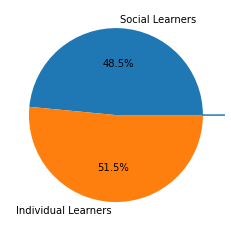

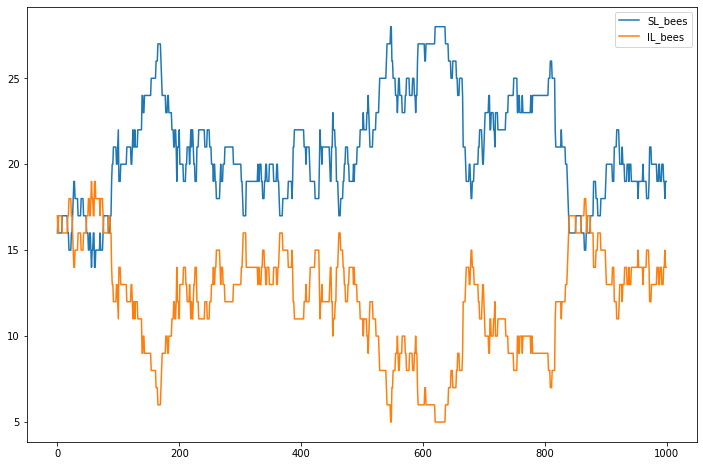

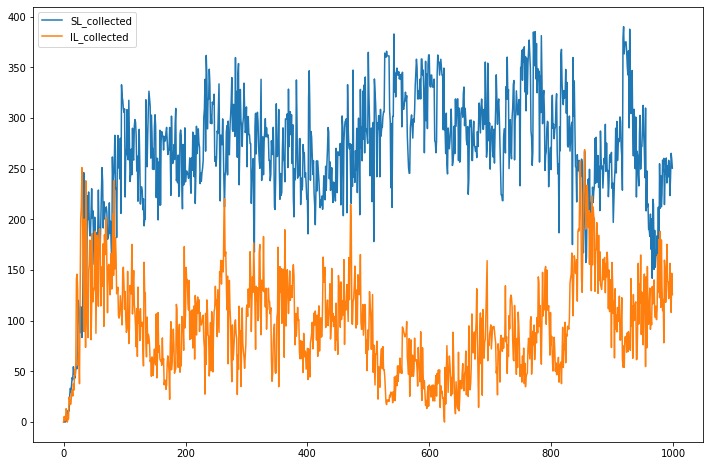

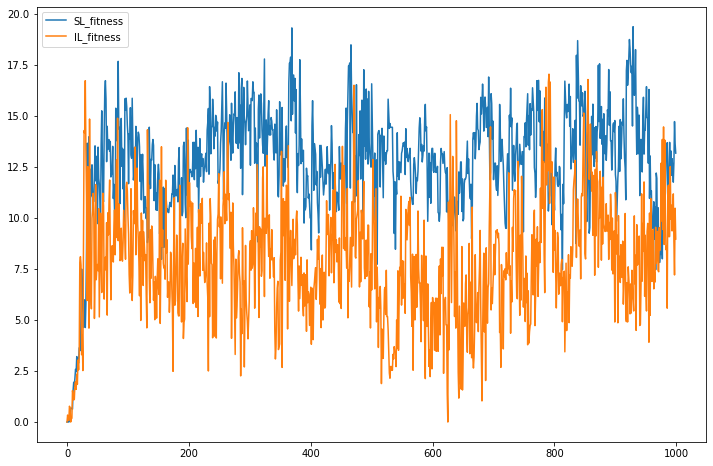

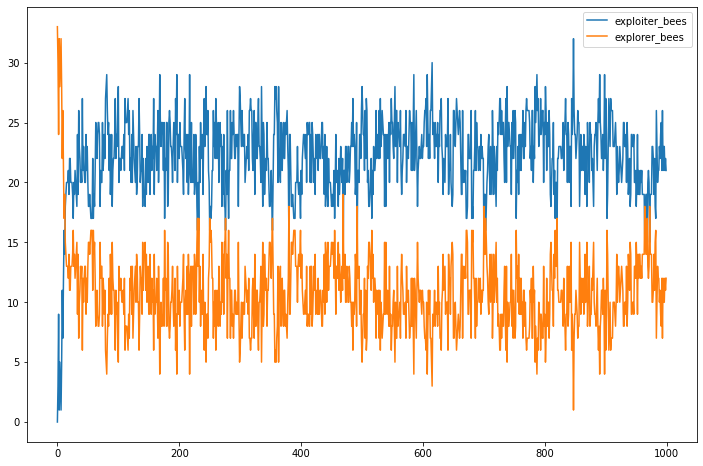

In [ ]:
variance = 'h' # h for high, n for no variance

patches = initialize_patches(n_patches, variance) # patches
bees = initailize_bees(n_individuals, n_patches) # bees

bee_action_history = dict()
history_summary = dict()

for t in range(1000):
  #print("Time: ", t)

  bees_alive, bees_SL, bees_IL = calculate_bee_stats(bees)
  bee_action = dict()
  for i in bees_alive:
    bee_action, bees = bee_act(bee_action, i, bees, explore_coeff, patches)
  
  bee_action_history, history_summary = update_stats(bees, bee_action, patches, bees_alive, bees_SL, bees_IL, patch_changes_coeff, n_patches, variance, death_coeff, t)
  timestep_stats(history_summary, t)
summ = summary_graphs(history_summary)

# No Variance mode

Streaming output truncated to the last 5000 lines.
Bee proportion --> Social / Individual :  0.8333333333333334
Net Resources:  829 Collected Resources:  174 Resource Efficiency:  21

Resources Breakdown: 174
-->Social Collected Resources:  53 -->Individual Collected Resources:  120

Bees Population Breakdown: 33
-->Social Bees:  15 -->Individual Bees:  18

Bee proportion --> Social / Individual :  0.8333333333333334
Net Resources:  829 Collected Resources:  174 Resource Efficiency:  21

Resources Breakdown: 174
-->Social Collected Resources:  70 -->Individual Collected Resources:  103

Bees Population Breakdown: 33
-->Social Bees:  15 -->Individual Bees:  18

Bee proportion --> Social / Individual :  0.8333333333333334
Net Resources:  829 Collected Resources:  199 Resource Efficiency:  24

Resources Breakdown: 199
-->Social Collected Resources:  95 -->Individual Collected Resources:  103

Bees Population Breakdown: 33
-->Social Bees:  15 -->Individual Bees:  18

Bee proportion --> Soc

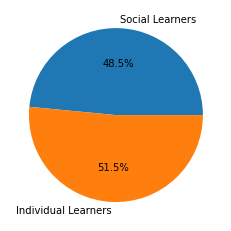

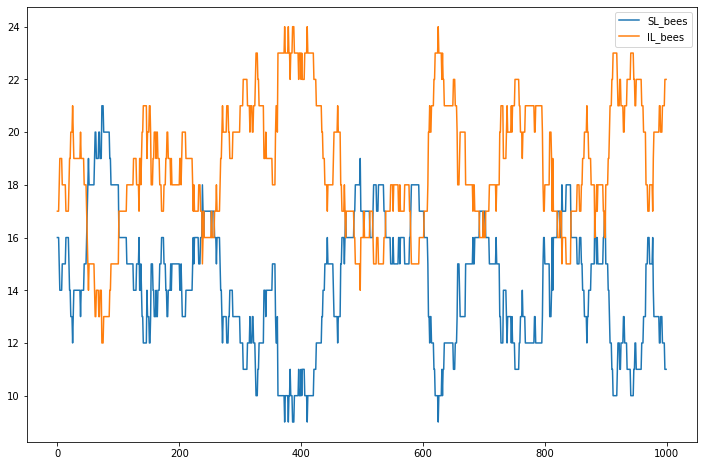

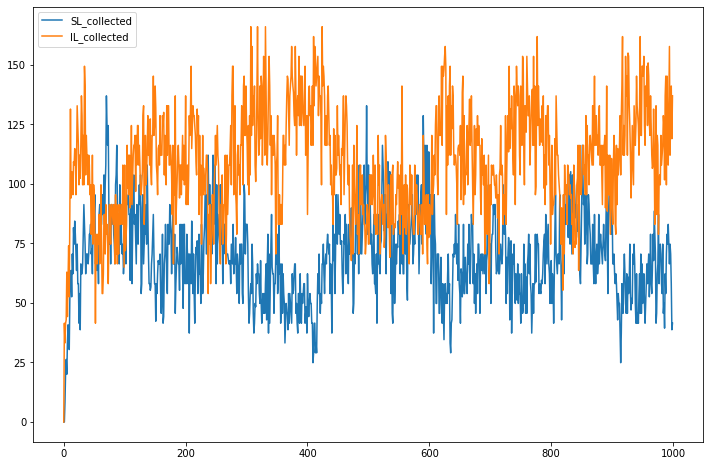

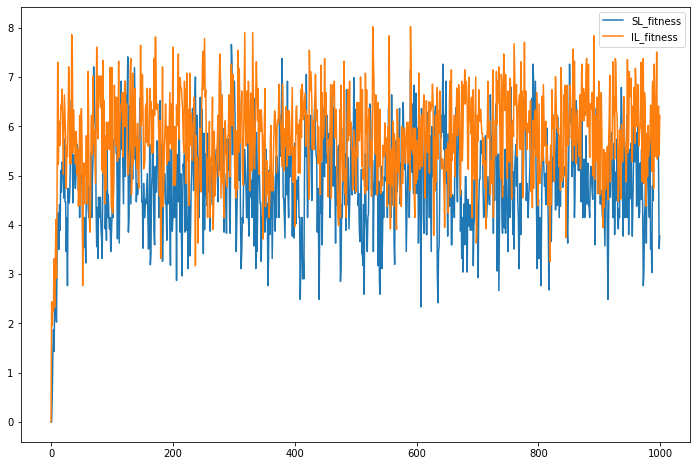

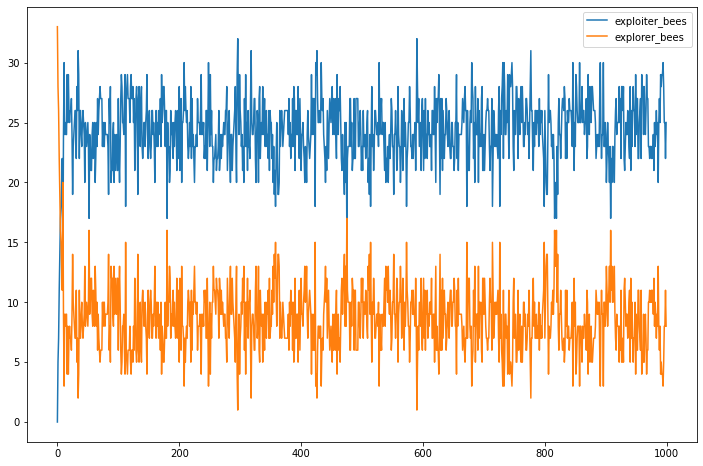

In [ ]:
variance = 'n' # h for high, n for no variance

patches = initialize_patches(n_patches, variance) # patches
bees = initailize_bees(n_individuals, n_patches) # bees

bee_action_history2 = dict()
history_summary2 = dict()

for t in range(1000):
  #print("Time: ", t)

  bees_alive, bees_SL, bees_IL = calculate_bee_stats(bees)
  bee_action = dict()
  for i in bees_alive:
    bee_action, bees = bee_act(bee_action, i, bees, explore_coeff, patches)
  
  bee_action_history2, history_summary2 = update_stats(bees, bee_action, patches, bees_alive, bees_SL, bees_IL, patch_changes_coeff, n_patches, variance, death_coeff, t)
  timestep_stats(history_summary, t)

summ2 = summary_graphs(history_summary)